In [1]:
# load the pridict, deepprime and conventional ML models
import os
import sys
import numpy as np
import pandas as pd
import pickle
import torch
import skorch

from models.deepprime import predict_deep_prime
from models.pridict import predict_pridict
from models.conventional_ml_models import MLP
from collections import defaultdict

# suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

dataf = 'pd-hek293t-pe2'

data_dp = f'dp-{dataf}.csv'
data_pd = f'pd-{dataf}.csv'

prediction_dp, _ = predict_deep_prime(data_dp, num_features=24, dropout=0)
prediction_pd, _ = predict_pridict(data_pd, num_features=24, device='cuda' if torch.cuda.is_available() else 'cpu', dropout=0)

prediction_mlp = defaultdict(list)
prediction_rf = defaultdict(list)
prediction_xgb = defaultdict(list)
prediction_ridge = defaultdict(list)
prediction_lasso = defaultdict(list)

data = pd.read_csv(f'models/data/conventional-ml/ml-{dataf}.csv')
for i in range(5):
    fold = i + 1
    # load the test data
    X_test = data[data['fold'] == i].iloc[:, :24].values
    y_test = data[data['fold'] == i].iloc[:, -2].values
    # load the models
    with open(f'models/trained-models/conventional-ml/random_forest-{dataf}-fold-{fold}.pkl', 'rb') as f:
        rf = pickle.load(f)
    with open(f'models/trained-models/conventional-ml/xgboost-{dataf}-fold-{fold}.pkl', 'rb') as f:
        xgb = pickle.load(f)
    with open(f'models/trained-models/conventional-ml/ridge-{dataf}-fold-{fold}.pkl', 'rb') as f:
        ridge = pickle.load(f)
    with open(f'models/trained-models/conventional-ml/lasso-{dataf}-fold-{fold}.pkl', 'rb') as f:
        lasso = pickle.load(f)
    mlp_model = skorch.NeuralNetRegressor(
            module=MLP,
            device='cuda',
            module__hidden_layer_sizes = (64, 64,),
        )
    mlp_model.initialize()
    mlp_model.load_params(f_params=f'models/trained-models/conventional-ml/mlp-{dataf}-fold-{fold}.pkl')

    prediction_rf[i] = rf.predict(X_test)
    prediction_xgb[i] = xgb.predict(X_test)
    prediction_ridge[i] = ridge.predict(X_test)
    prediction_lasso[i] = lasso.predict(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    prediction_mlp[i] = mlp_model.predict(X_test)

99
Fold 1 Pearson: 0.8387605127177715, Spearman: 0.8313111807914643
99
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Fold 2 Pearson: 0.7690840935269022, Spearman: 0.7648829038004931
99
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Fold 3 Pearson: 0.8474246047420366, Spearman: 0.8483193479830236
99
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Fold 4 Pearson: 0.8065597544294233, Spearman: 0.8290010614276513
99
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Fold 5 Pearson: 0.8009566564529758, Spearman: 0.8112355093058988
Fold 1 Pearson: 0.7733736578577216, Spearman: 0.8086266722163329
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Fold 2 Pearson: 0.7877185665268994, Spearman: 0.800966284973719
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Fold 3 Pearson: 0.7949743459820964, Spearman: 0.823249747282362

Concatenated
DeepPrime: 335.3712089502738
Pridict: 356.8097742247133
Random Forest: 910.8263186941646
XGBoost: 1538.7755640504834
Ridge: 1520.9245791500402
Lasso: 1782.152513198304
MLP: 2188.5353419002918
DeepPrime: 0.8098688374995655
Pridict: 0.7977362093665209
Random Forest: 0.276209860435789
XGBoost: 0.07458082007000659
Ridge: 0.09982252701639538
Lasso: 0.04690301145903483
MLP: -0.15934200932005946


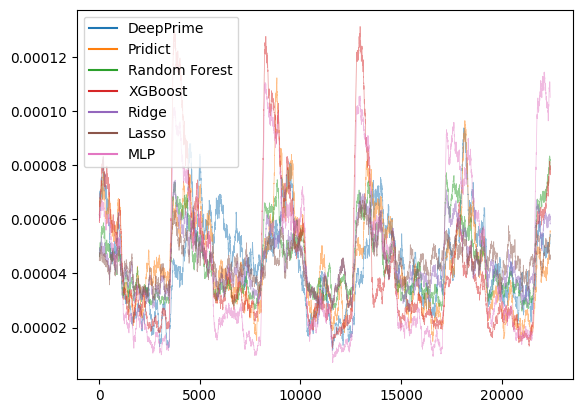

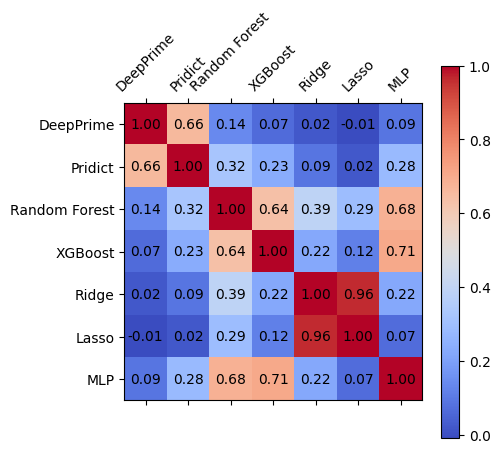

In [12]:
# concatenate the predictions for each fold into a single array
prediction_pd_list = np.concatenate([prediction_pd[fold].flatten() for fold in range(5)])
prediction_dp_list = np.concatenate([prediction_dp[fold].flatten() for fold in range(5)])
prediction_rf_list = np.concatenate([prediction_rf[fold] for fold in range(5)])
prediction_xgb_list = np.concatenate([prediction_xgb[fold] for fold in range(5)])
prediction_ridge_list = np.concatenate([prediction_ridge[fold] for fold in range(5)])
prediction_lasso_list = np.concatenate([prediction_lasso[fold] for fold in range(5)])
prediction_mlp_list = np.concatenate([prediction_mlp[fold].flatten() for fold in range(5)])

print('Concatenated')

# calculate the squared error from the predictions
y_test = np.concatenate([data[data['fold'] == i].iloc[:, -2].values for i in range(5)])
mse_dp = (y_test - prediction_dp_list)**2
mse_pd = (y_test - prediction_pd_list)**2
mse_rf = (y_test - prediction_rf_list)**2
mse_xgb = (y_test - prediction_xgb_list)**2
mse_ridge = (y_test - prediction_ridge_list)**2
mse_lasso = (y_test - prediction_lasso_list)**2
mse_mlp = (y_test - prediction_mlp_list)**2

# print the mse of each model
print('DeepPrime:', np.sum(mse_dp) / len(mse_dp))
print('Pridict:', np.sum(mse_pd) / len(mse_pd))
print('Random Forest:', np.sum(mse_rf) / len(mse_rf))
print('XGBoost:', np.sum(mse_xgb) / len(mse_xgb))
print('Ridge:', np.sum(mse_ridge) / len(mse_ridge))
print('Lasso:', np.sum(mse_lasso) / len(mse_lasso))
print('MLP:', np.sum(mse_mlp) / len(mse_mlp))

# print the pearson correlation coefficient between model predictions and true values
from scipy.stats import pearsonr
print('DeepPrime:', pearsonr(y_test, prediction_dp_list)[0])
print('Pridict:', pearsonr(y_test, prediction_pd_list)[0])
print('Random Forest:', pearsonr(y_test, prediction_rf_list)[0])
print('XGBoost:', pearsonr(y_test, prediction_xgb_list)[0])
print('Ridge:', pearsonr(y_test, prediction_ridge_list)[0])
print('Lasso:', pearsonr(y_test, prediction_lasso_list)[0])
print('MLP:', pearsonr(y_test, prediction_mlp_list)[0])

# normalize the squared error
mse_dp = mse_dp / np.sum(mse_dp)
mse_pd = mse_pd / np.sum(mse_pd)
mse_rf = mse_rf / np.sum(mse_rf)
mse_xgb = mse_xgb / np.sum(mse_xgb)
mse_ridge = mse_ridge / np.sum(mse_ridge)
mse_lasso = mse_lasso / np.sum(mse_lasso)
mse_mlp = mse_mlp / np.sum(mse_mlp)


# plot the smoothened error using a moving average
import matplotlib.pyplot as plt
import seaborn as sns

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

window = 200
plt.plot(moving_average(mse_dp, window), label='DeepPrime')
plt.plot(moving_average(mse_pd, window), label='Pridict')
plt.plot(moving_average(mse_rf, window), label='Random Forest')
plt.plot(moving_average(mse_xgb, window), label='XGBoost')
plt.plot(moving_average(mse_ridge, window), label='Ridge')
plt.plot(moving_average(mse_lasso, window), label='Lasso')
plt.plot(moving_average(mse_mlp, window), label='MLP')
plt.legend()


# reduce thickness and alpha of the lines
for line in plt.gca().lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)


# calculate the pearson correlation coefficient between each error and plot in heatmap
from scipy.stats import pearsonr

mse_dict = {
    'DeepPrime': mse_dp,
    'Pridict': mse_pd,
    'Random Forest': mse_rf,
    'XGBoost': mse_xgb,
    'Ridge': mse_ridge,
    'Lasso': mse_lasso,
    'MLP': mse_mlp,
}

correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
for i, mse in enumerate(mse_dict.values()):
    for j, mse2 in enumerate(mse_dict.values()):
        correlation_matrix[i, j] = pearsonr(mse, mse2)[0]

plt.matshow(correlation_matrix, cmap=sns.color_palette('coolwarm', as_cmap=True))
plt.colorbar()
plt.xticks(range(len(mse_dict)), mse_dict.keys(), rotation=45)
plt.yticks(range(len(mse_dict)), mse_dict.keys())
# show true values on the heatmap
for i in range(len(mse_dict)):
    for j in range(len(mse_dict)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')